In [1]:
from math import sqrt
from scipy.fft import fft
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

import numpy as np
from scipy.ndimage import maximum_filter

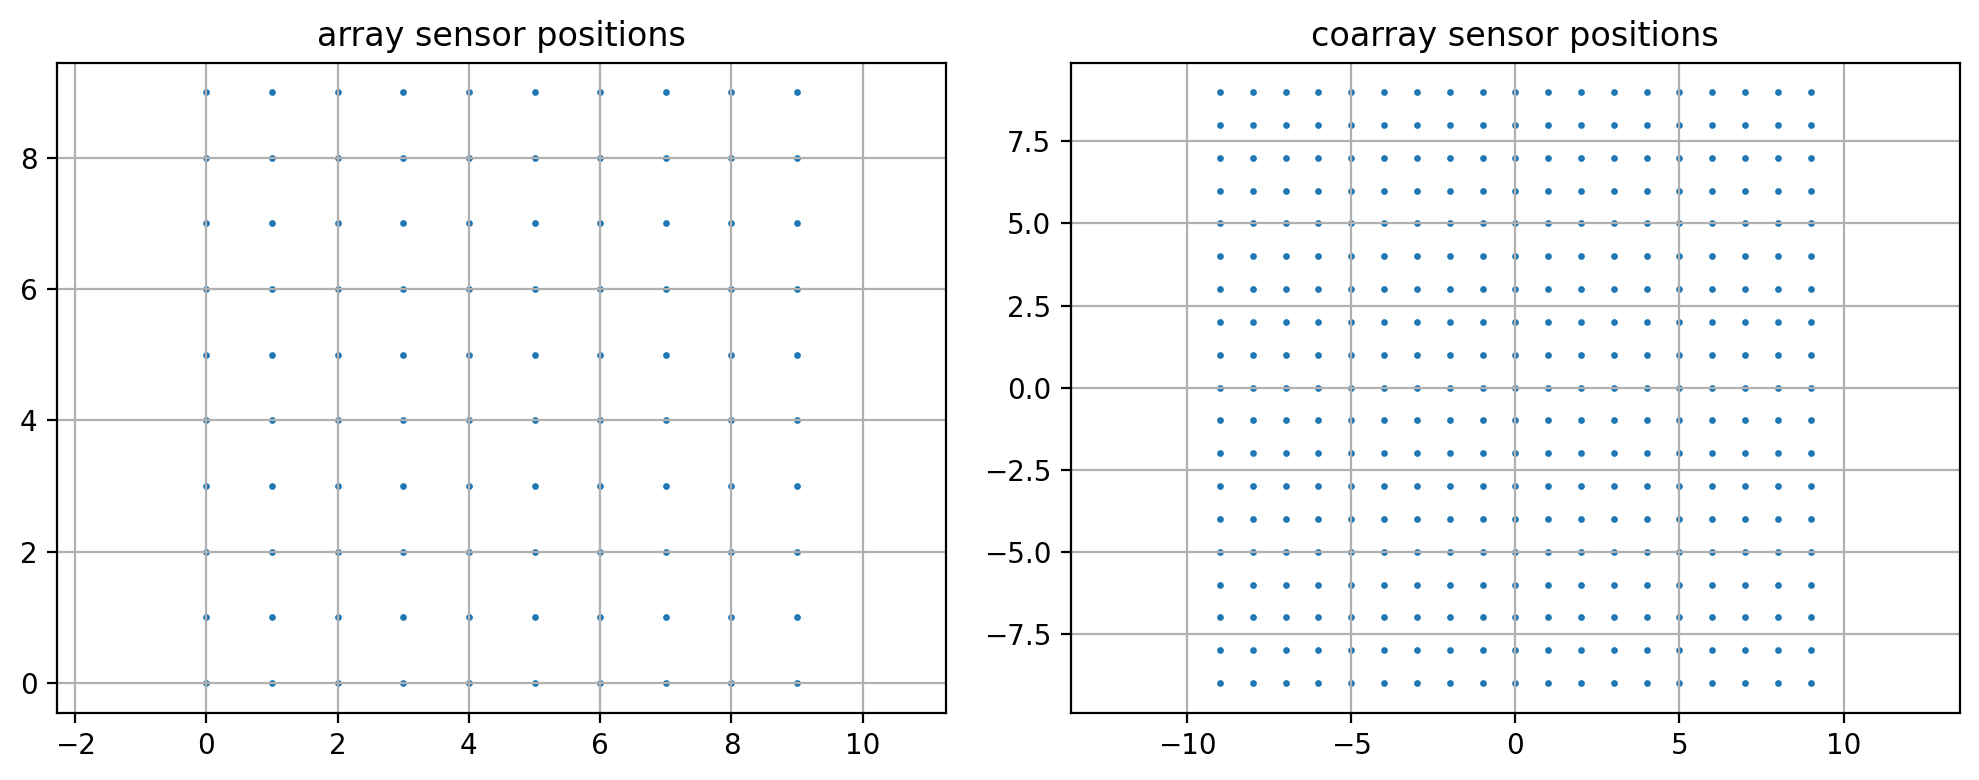

In [2]:
size_horizontal = 10
size_vertical = 10

nbSensors = size_horizontal * size_vertical

x, y = [], []

pos_horizontal = np.arange(size_horizontal)
pos_vertical = np.arange(size_vertical)

x = np.tile(np.array(pos_horizontal), size_vertical).tolist()
y = np.repeat(np.array(pos_vertical), size_horizontal).tolist()

pos_coarray_set = set()
for i in range(nbSensors):
    for j in range(nbSensors):
        pos_coarray_set.add((x[i] - x[j], y[i] - y[j]))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(x, y, s=2)
axes[0].set_title('array sensor positions')
axes[0].axis('equal')
axes[0].grid(True)

# Second subplot
axes[1].scatter(np.array(list(pos_coarray_set))[:, 0], np.array(list(pos_coarray_set))[:, 1], s=2)
axes[1].set_title('coarray sensor positions')
axes[1].axis('equal')
axes[1].grid(True)

# Improve layout
plt.tight_layout()
plt.show()

In [3]:
len(pos_coarray_set)

361

In [4]:
t = 200
nbSources = 5
snr = 20

theta = np.random.rand(nbSources) * np.pi / 2
phi = np.random.rand(nbSources) * np.pi 
d_lamda_ratio = 1 / 2

A = np.exp(1j * 2 * np.pi * d_lamda_ratio * (np.array(x).reshape(-1, 1) * (np.sin(theta) * np.cos(phi)).reshape(1, -1) \
                                           + np.array(y).reshape(-1, 1) * (np.sin(theta) * np.sin(phi)).reshape(1, -1)))
S = (np.random.randn(nbSources, t) + 1j * np.random.randn(nbSources, t)) / sqrt(2)
N = (np.random.randn(nbSensors, t) + 1j * np.random.randn(nbSensors, t)) / sqrt(2) * sqrt(nbSources) * 10 ** (-snr/20)

X = A @ S + N

In [5]:
pos_coarray_dict = {}
for pos in pos_coarray_set: pos_coarray_dict[pos] = []

for i in range(nbSensors):
    for j in range(nbSensors):
        pos = (x[i] - x[j], y[i] - y[j])
        pos_coarray_dict[pos].append((i, j))

R = X @ X.T.conj() / t
coarray_covariance = {}

for pos, indices in pos_coarray_dict.items():
    indices = np.array(indices)
    values = np.mean(R[indices[:, 0], indices[:, 1]])
    coarray_covariance[pos] = values

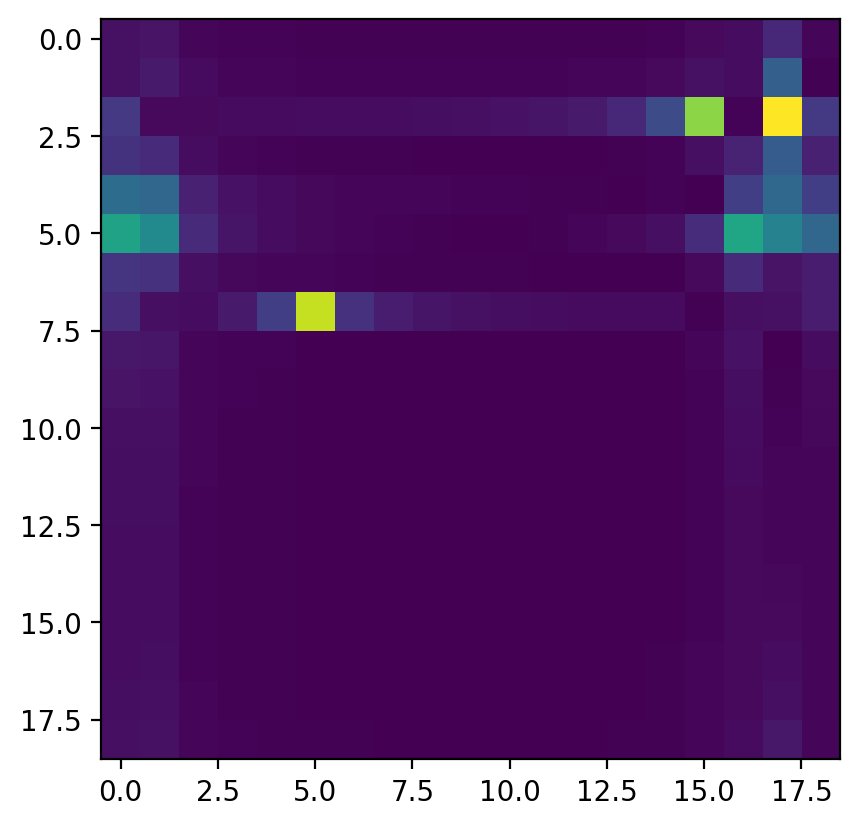

In [6]:
size_x_coarray = size_horizontal - 1
size_y_coarray = size_vertical - 1

R_coarray = []
for j in range(- size_y_coarray, size_y_coarray + 1):
    for i in range(- size_x_coarray, size_x_coarray + 1):
        R_coarray.append(coarray_covariance[(i, j)])
R_coarray = np.array(R_coarray).reshape(2 * size_y_coarray + 1, 2 * size_x_coarray + 1)

fft_R_coarray = np.abs(fft(fft(R_coarray, axis=0), axis=1))
plt.imshow(fft_R_coarray);

In [7]:
def arctan2_custom(y, x):
    angle = np.arctan2(y, x)
    angle = np.where(angle < 0, angle + np.pi * 2, angle)
    angle = np.where(angle > np.pi, 2 * np.pi - angle, angle)
    return angle  

matrix = np.array(fft_R_coarray)
neighborhood = maximum_filter(matrix, size=3, mode='constant', cval=-np.inf)
peaks_mask = (matrix == neighborhood)

for shift in [(-1,0), (1,0), (0,-1), (0,1)]:
    shifted = np.roll(matrix, shift, axis=(0,1))
    mask = np.ones_like(matrix, dtype=bool)
    if shift[0] == -1:
        mask[0,:] = False
    elif shift[0] == 1:
        mask[-1,:] = False
    if shift[1] == -1:
        mask[:,0] = False
    elif shift[1] == 1:
        mask[:,-1] = False
    peaks_mask &= (matrix > shifted) | ~mask  

peak_indices = np.argwhere(peaks_mask)
peak_values = matrix[peaks_mask]
sorted_indices = np.argsort(-peak_values)
top_peaks = [(peak_indices[i]) for i in sorted_indices[:nbSources]]

results = []

for j, i in top_peaks:
    if i <= (2 * size_x_coarray + 1) * d_lamda_ratio: b1 = - i / (d_lamda_ratio * (2 * size_x_coarray + 1))
    else: b1 = (1 - i / (2 * size_x_coarray + 1)) / d_lamda_ratio
    if j <= (2 * size_y_coarray + 1) * d_lamda_ratio: b2 = - j / (d_lamda_ratio * (2 * size_y_coarray + 1))
    else: b2 = (1 - j / (2 * size_y_coarray + 1)) / d_lamda_ratio
    results.append([np.arcsin(np.sqrt(b1 ** 2 + b2 ** 2)), arctan2_custom(- b2, - b1)])

results = np.array(results)

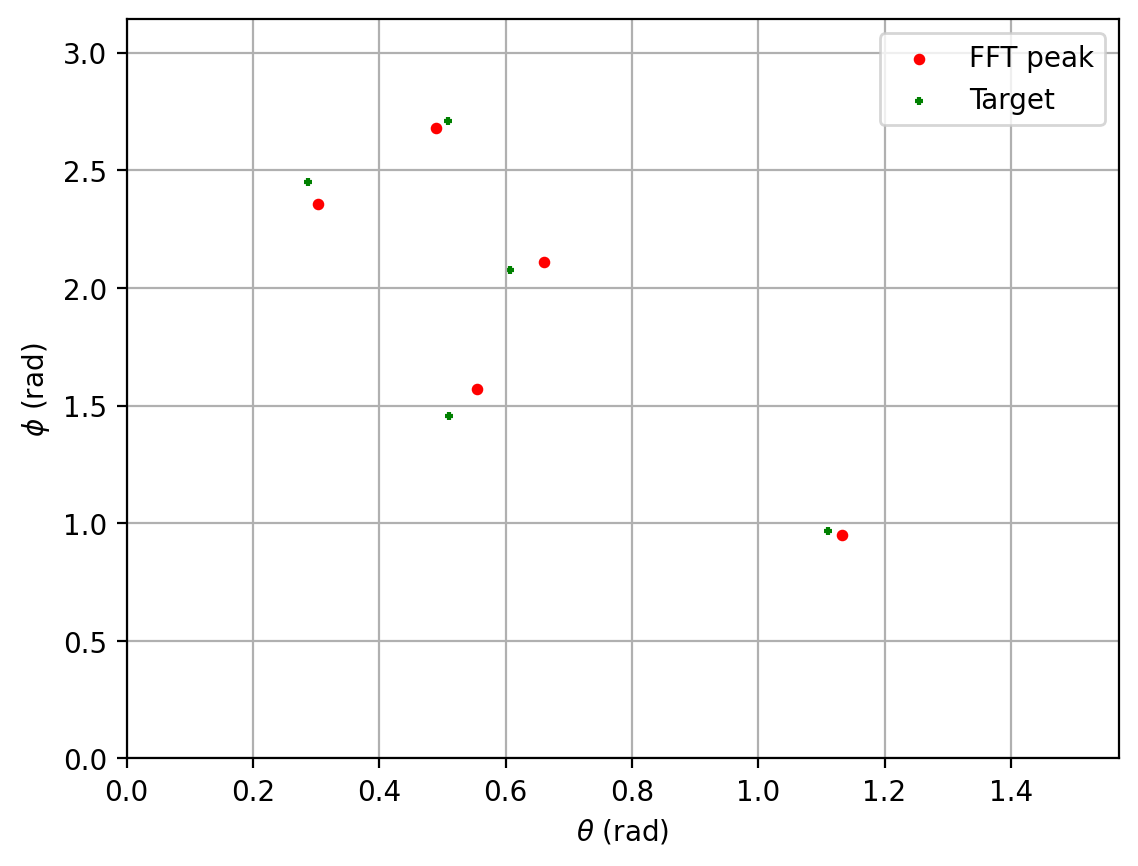

In [8]:
plt.scatter(results[:, 0], results[:, 1], marker='o', color='red', s=10, label='FFT peak')  # Circle marker
plt.scatter(theta, phi, marker='+', color='green', s=10, label='Target')  # X marker

plt.xlim(0, np.pi / 2) 
plt.ylim(0, np.pi)  

plt.xlabel(r'$\theta$ (rad)')
plt.ylabel(r'$\phi$ (rad)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()